# Deeper MLP using NumPy
In this notebook, we attempt to build a multi-layer MLP to perform multi-class classification on generated data. We following up by experimenting with different model architectures and adding regularization. Finally we will perform multi-class prediction on a dataset of our choosing.

We start by re-using the code from the previous notebook to generate the data:

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Re-using code from HW Question
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,-1.714458,0.774599,0.0
1,0.541959,-0.255407,0.0
2,1.364808,1.041758,2.0
3,0.804678,1.105461,2.0
4,0.815451,0.787206,2.0


In [3]:
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

X = np.matrix(X.values)
y = np.matrix(y.values)

We will also re-use the plotting function:

In [4]:
#Re-using plotting function from HW
def plot_data(X, y_predict, plot_title):
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(plot_title)
    plt.show()

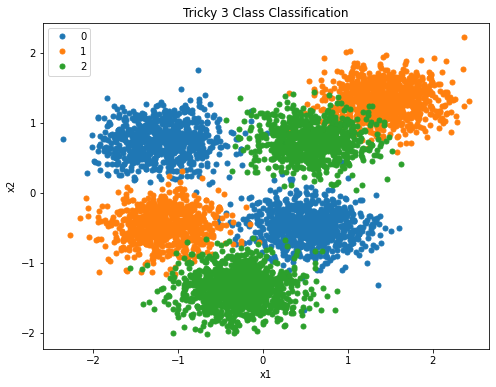

In [5]:
plot_data(X, y, 'Tricky 3 Class Classification')

## (a) Building the Network

We will first define the classes for a Hidden Layer, Output Layer and the Loss Layer. Each will have separate forward and backward functions:

In [6]:
#Fix the seed value
np.random.seed(29)

In [7]:
#Utility function to plot loss
def plot_loss(train_loss_values):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(train_loss_values, color='red')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title('Loss vs epoch')
    plt.show()
    return
    

In [8]:
#Hidden Layer Class
class hidden_layer():
    def __init__(self, dim_in=2, dim_out=16):
        #initialize weights, biases
        self.W = np.random.uniform(low=-1, high=1, size=(dim_in, dim_out)) 
        self.b = np.random.uniform(low=-1, high=1, size=(dim_out, 1))
        self.out = {}
        self.grad = {}
        
    #Function to perform forward prop
    def forward(self, input):
        val1 = (self.W).T @ input
        val2 = val1 + np.repeat(self.b, val1.shape[1], axis = 1)
        #Apply relu and store output
        val2[val2 < 0] = 0
        self.out['output'] = val2
        return self.out
    
    #Function to perform backprop
    def backward(self, prev_weights, prev_grad, input):
        dh = prev_weights @ prev_grad
        dh = np.where(self.out['output'] == 0, 0, dh)
        db = np.expand_dims(np.sum(dh, axis=1), axis=1)
        dW = input @ dh.T                                     
        #Store gradients and return layer gradient, layer weight
        self.grad['layer_grad'] = dh
        self.grad['bias_grad'] = db
        self.grad['weight_grad'] = dW
        return self.grad, self.W
    
    #Function to update weights of the layer
    def update(self, learning_rate, reg, batch_size):
        #SGD Weight Update with L2 regularization
        self.W = self.W - learning_rate * (self.grad['weight_grad'] + batch_size*(reg * self.W))
        self.b = self.b - learning_rate * (self.grad['bias_grad'] + batch_size*(reg * self.b))
        return
    

In [9]:
#Output Layer Class
class output_layer():
    def __init__(self, dim_in=2, dim_out=16):
        self.W = np.random.uniform(low=-1, high=1, size=(dim_in, dim_out))
        self.b = np.random.uniform(low=-1, high=1, size=(dim_out, 1))
        self.out = {}
        self.grad = {}
    
    #Function to perform forward prop 
    def forward(self, input):
        val1 = (self.W).T @ input
        val2 = val1 + np.repeat(self.b, val1.shape[1], axis = 1)
        #No ReLU here, linear layer so just store output and return
        self.out['output'] = val2
        return self.out
    
    #Function to perform backprop
    def backward(self, input, target, softmax_outputs):
        target_vector = np.zeros(softmax_outputs.shape)                   
        
        for i in range(target.shape[1]):
            target_vector[int(target[0, i]), i] = 1
        
        dz = softmax_outputs - target_vector
        db = np.sum(dz, axis=1)
        dW = input @ dz.T
        #Store gradients and return layer gradient, layer weight
        self.grad['layer_grad'] = dz
        self.grad['bias_grad'] = db
        self.grad['weight_grad'] = dW
        
        return self.grad, self.W
    
    #Function to update weights of the layer
    def update(self, learning_rate, reg, batch_size):
        #SGD Weight Update with L2 regularization
        self.W = self.W - learning_rate * (self.grad['weight_grad'] + batch_size*(reg * self.W))
        self.b = self.b - learning_rate * (self.grad['bias_grad'] + batch_size*(reg * self.b))
        return
        

In [192]:
#Loss Layer Class
class softmax_layer():
    def __init__(self):
        self.out = {}
    
    #Function to perform forward prop (compute loss)
    def forward(self, input, target):
        val1 = np.exp(input)
        val2 = val1/np.sum(val1, axis=0)
        self.out['output'] = val2
        #Cross-Entropy loss
        loss_val = np.log(np.sum(val1, axis=0))
        for i in range(target.shape[1]):
            loss_val[0, i] -= input[int(target[0, i]), i]
        #Store loss and return it
        self.out['loss'] = np.sum(loss_val)
        return self.out
    

Next, we will define our MLP class. The class will have a function to add layers, a function to perform forward prop across the network, a function to perform backprop across the network, a function to train the network and a function to perform prediction on a given input.

In [198]:
#MLP Network main class
class MLP():
    def __init__(self):
        self.all_layers = []
        self.inputs_to_layers = []
        self.loss_values = []
    
    #Function to add a layer to the network
    def add_layer(self, type='Hidden', dim_in=2, dim_out=16):
        if type == 'Hidden':
            new_layer = hidden_layer(dim_in, dim_out)
        elif type == 'Output':
            new_layer = output_layer(dim_in, dim_out)
        elif type == 'Softmax':
            new_layer = softmax_layer()
        else:
            print(f"{type} layer does not exist")
        #Add to list of layers
        self.all_layers.append(new_layer)
        
        return
    
    #Function to perform forward prop across the network
    def forward_propagation(self, input, target):
        prev_out = input
        self.inputs_to_layers.append(prev_out)
        num_layers = len(self.all_layers)
        #iterate through all layers except the final softmax layer
        for i in range(num_layers - 1):
            curr_layer = self.all_layers[i]
            curr_out = curr_layer.forward(prev_out)
            prev_out = curr_out['output']
            self.inputs_to_layers.append(prev_out)
        #iterate through the final softmax layer
        last_layer = self.all_layers[num_layers - 1]
        last_out = last_layer.forward(prev_out, target)
        #loss value of the network
        loss_val = last_out['loss']
        
        return loss_val, last_out['output']
    
    #Function to perform backprop across the network
    def backward_propagation(self, softmax_outputs, target):
        num_layers = len(self.all_layers)
        #First do backprop on the output layer
        out_layer = self.all_layers[num_layers - 2]
        prev_grad, prev_W = out_layer.backward(self.inputs_to_layers[num_layers - 2], target, softmax_outputs)
        #backprop on the other layers
        for i in range(num_layers - 3, -1, -1):
            curr_layer = self.all_layers[i]
            curr_grad, curr_W = curr_layer.backward(prev_W, prev_grad['layer_grad'], self.inputs_to_layers[i])
            prev_grad = curr_grad
            prev_W = curr_W
            
        return
    
    #Function to update weights of the network
    def update_layers(self, learning_rate, reg, batch_size):
        num_layers = len(self.all_layers)
        #Update the weights and biases of all layers in reverse
        for i in range(num_layers - 2, -1, -1):
            curr_layer = self.all_layers[i]
            curr_layer.update(learning_rate, reg, batch_size)
        
        return
    
    #Function to train the network
    def train(self, train_X, train_y, epochs=100, bsize=8, learning_rate=0.001, L2_reg_factor=0, val_X=None, val_y=None, val_threshold=1.):
        train_len = train_X.shape[0]
        #Epochs
        for e in range(epochs):
            loss_epoch = 0
            batch_count = 0
            #Iterate through each batch
            for idx in range(0, train_len, bsize):
                batch_input = train_X[idx:idx + bsize]
                batch_input = batch_input.T
                batch_target = train_y[idx:idx + bsize]
                batch_target = batch_target.T
                loss_val, softmax_outputs = self.forward_propagation(batch_input, batch_target)
                loss_epoch += loss_val
                batch_count += 1
                self.backward_propagation(softmax_outputs, batch_target)
                self.update_layers(learning_rate, L2_reg_factor, bsize)
                self.inputs_to_layers.clear()
            loss_epoch /= batch_count
            self.loss_values.append(loss_epoch)
            print('Training epoch ',(e+1),'... Loss: ',loss_epoch)
            #Compute validation accuracy after the batch gradient descent and stop if threshold is reached
            if val_X is not None and val_y is not None:
                val_pred = self.prediction(val_X.T)
                val_length = val_X.shape[0]
                correct = np.sum(val_pred == val_y.T)
                val_acc = correct/val_length
                print('Validation Accuracy: ',(val_acc*100))
                #Early Stopping
                if val_acc >= val_threshold:
                    print('Reached validation threshold so stopped training.')
                    return self.loss_values
         
        return self.loss_values
    
    #Function to perform prediction
    def prediction(self, input):
        prev_out = input
        num_layers = len(self.all_layers)
        #iterate through all layers except the final softmax layer
        for i in range(num_layers - 1):
            curr_layer = self.all_layers[i]
            curr_out = curr_layer.forward(prev_out)
            prev_out = curr_out['output']
        pred = np.argmax(prev_out, axis=0)
        
        return pred

Finally, we initialize and train the network. We will use 3 Hidden layers of (64, 32, 32) nodes, 1 output layer of 3 nodes since we have 3 classes, and our softmax loss layer. We will train for 50 epochs with a learning rate of $10^{-5}$ and a regularization factor of $0.015$.

Training epoch  1 ... Loss:  23.229041335518772
Validation Accuracy:  51.0
Training epoch  2 ... Loss:  9.056279173247912
Validation Accuracy:  66.9
Training epoch  3 ... Loss:  5.670153399434878
Validation Accuracy:  70.89999999999999
Training epoch  4 ... Loss:  4.186866095261933
Validation Accuracy:  76.0
Training epoch  5 ... Loss:  3.417433880378531
Validation Accuracy:  84.2
Training epoch  6 ... Loss:  2.963421110319922
Validation Accuracy:  87.1
Training epoch  7 ... Loss:  2.662184663235651
Validation Accuracy:  89.0
Training epoch  8 ... Loss:  2.4452282606251456
Validation Accuracy:  90.5
Training epoch  9 ... Loss:  2.277808981927557
Validation Accuracy:  91.0
Training epoch  10 ... Loss:  2.143840061929931
Validation Accuracy:  91.60000000000001
Training epoch  11 ... Loss:  2.033268413851694
Validation Accuracy:  91.8
Training epoch  12 ... Loss:  1.9403421149760718
Validation Accuracy:  92.2
Training epoch  13 ... Loss:  1.8609757228120394
Validation Accuracy:  92.7
Trai

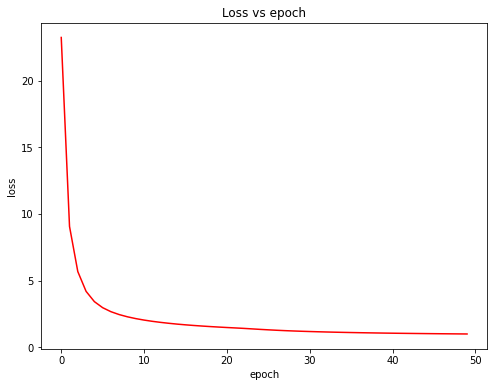

In [199]:
#Initialize the network and add layers
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=64)
NN.add_layer('Hidden', dim_in=64, dim_out=32)
NN.add_layer('Hidden', dim_in=32, dim_out=32)
NN.add_layer('Output', dim_in=32, dim_out=3)
NN.add_layer('Softmax', dim_in=3, dim_out=3)

total_len = X.shape[0]
#Randomly shuffle the dataset
permu = np.random.permutation(X.shape[0])
X = X[permu, :]
y = y[permu, :]

#Split Data into train, validation sets
train_X = X[:int((0.8)*total_len), :]
val_X = X[int((0.8)*total_len):, :]

train_y = y[:int((0.8)*total_len), :]
val_y = y[int((0.8)*total_len):, :]

#Train the network
loss = NN.train(train_X, train_y, epochs=50, bsize=8, learning_rate=1e-5, L2_reg_factor=0.015, val_X=val_X, val_y=val_y)
plot_loss(loss)

## (b) Visualizing the decision boundary
We can visualize the decision boundary of our model by generating dense points and performing prediction on them:

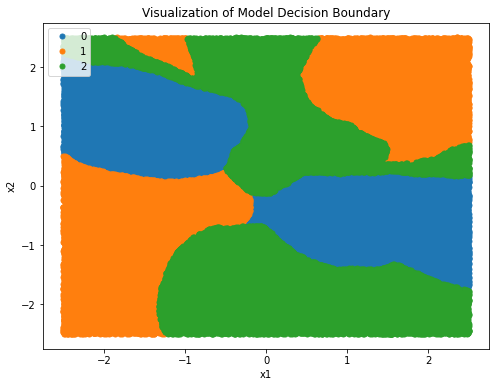

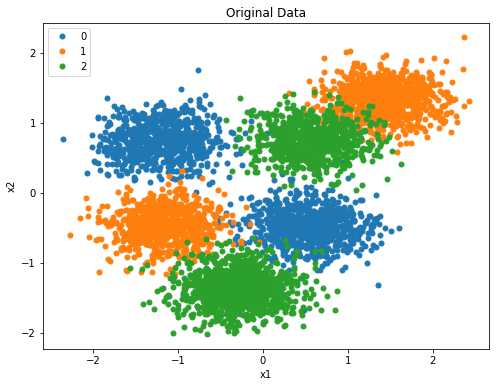

In [200]:
#Dense points generated uniformly
dummy_data = np.random.uniform(low=-2.5, high=2.5, size=(2, 100000))
#Perform prediction on the dummy data
pred = NN.prediction(dummy_data)
#Plot the results
plot_data(dummy_data.T, pred.T, 'Visualization of Model Decision Boundary')
#Plot the original data
plot_data(X, y, 'Original Data')

## (c) Repeating with different architectures
We will repeat the same with three different architectures:
<ul>
    <li>1 Hidden Layer, 16 units</li>
    <li>2 Hidden Layers, (16,16) units</li>
    <li>3 Hidden Layers, (16,8,3) units</li>
</ul>
</br>
We will initialize and train three separate models. All models will have a 3-unit output and softmax loss layer since we have 3 classes. We will first perform the training with no regularization:

*****Training Network 1*****
Training epoch  1 ... Loss:  10.914807843780874
Validation Accuracy:  36.0
Training epoch  2 ... Loss:  8.18363769903262
Validation Accuracy:  60.9
Training epoch  3 ... Loss:  7.235189027864634
Validation Accuracy:  61.199999999999996
Training epoch  4 ... Loss:  6.75455935139375
Validation Accuracy:  63.2
Training epoch  5 ... Loss:  6.420710738972884
Validation Accuracy:  66.60000000000001
Training epoch  6 ... Loss:  6.158822036261248
Validation Accuracy:  68.5
Training epoch  7 ... Loss:  5.93982823698855
Validation Accuracy:  69.5
Training epoch  8 ... Loss:  5.749194408300786
Validation Accuracy:  70.1
Training epoch  9 ... Loss:  5.577395429733909
Validation Accuracy:  70.3
Training epoch  10 ... Loss:  5.4196591924681305
Validation Accuracy:  70.7
Training epoch  11 ... Loss:  5.273050403121144
Validation Accuracy:  72.0
Training epoch  12 ... Loss:  5.135328063204733
Validation Accuracy:  73.5
Training epoch  13 ... Loss:  5.005247595241729
Valida

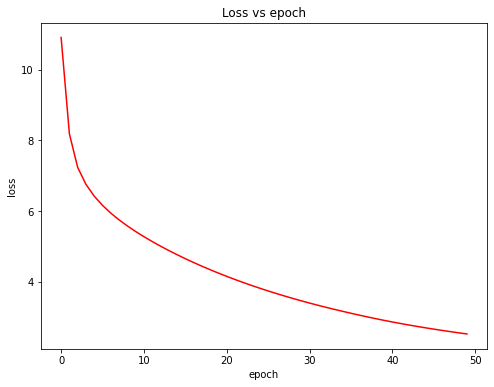

*****Training Network 2*****
Training epoch  1 ... Loss:  16.044858602608667
Validation Accuracy:  38.7
Training epoch  2 ... Loss:  8.751216739599467
Validation Accuracy:  81.10000000000001
Training epoch  3 ... Loss:  6.509811093192534
Validation Accuracy:  81.3
Training epoch  4 ... Loss:  5.271215663176928
Validation Accuracy:  81.3
Training epoch  5 ... Loss:  4.525361307062586
Validation Accuracy:  82.0
Training epoch  6 ... Loss:  4.048367779383175
Validation Accuracy:  83.8
Training epoch  7 ... Loss:  3.6914902503093163
Validation Accuracy:  86.8
Training epoch  8 ... Loss:  3.39961889304204
Validation Accuracy:  88.4
Training epoch  9 ... Loss:  3.147704603629437
Validation Accuracy:  91.0
Training epoch  10 ... Loss:  2.9318029429375043
Validation Accuracy:  91.9
Training epoch  11 ... Loss:  2.748915457037284
Validation Accuracy:  92.10000000000001
Training epoch  12 ... Loss:  2.5941280889293608
Validation Accuracy:  92.5
Training epoch  13 ... Loss:  2.4620609162094595
Va

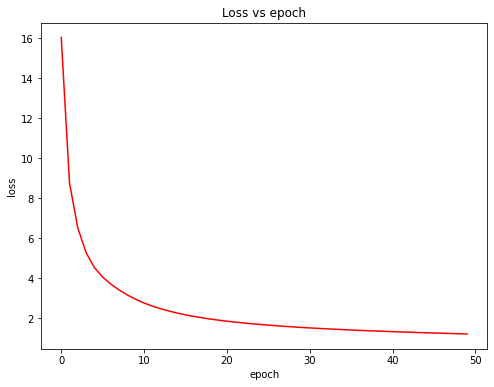

*****Training Network 3*****
Training epoch  1 ... Loss:  9.848324855519456
Validation Accuracy:  28.9
Training epoch  2 ... Loss:  8.995007798919213
Validation Accuracy:  28.9
Training epoch  3 ... Loss:  8.868061342958027
Validation Accuracy:  28.9
Training epoch  4 ... Loss:  8.80989711600744
Validation Accuracy:  28.9
Training epoch  5 ... Loss:  8.764988428457263
Validation Accuracy:  28.999999999999996
Training epoch  6 ... Loss:  8.726734883391254
Validation Accuracy:  28.999999999999996
Training epoch  7 ... Loss:  8.692155600274507
Validation Accuracy:  29.099999999999998
Training epoch  8 ... Loss:  8.659440624228894
Validation Accuracy:  36.3
Training epoch  9 ... Loss:  8.627049648930166
Validation Accuracy:  36.3
Training epoch  10 ... Loss:  8.593423381267865
Validation Accuracy:  36.3
Training epoch  11 ... Loss:  8.556806125397864
Validation Accuracy:  36.3
Training epoch  12 ... Loss:  8.514792863029989
Validation Accuracy:  36.3
Training epoch  13 ... Loss:  8.4664354

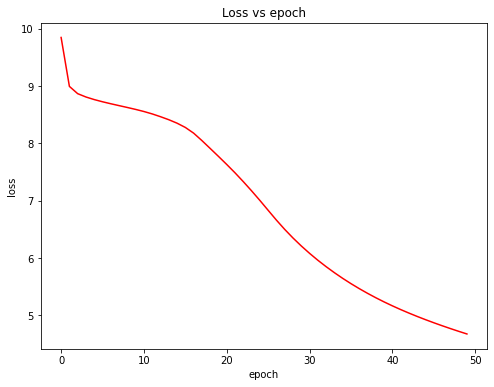

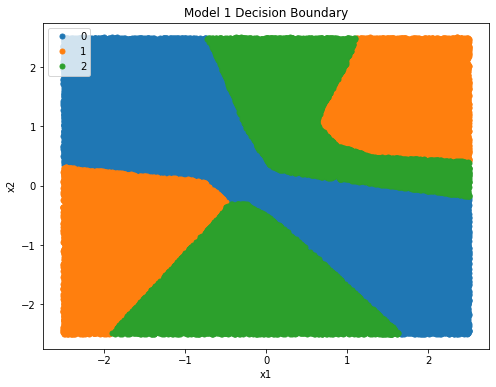

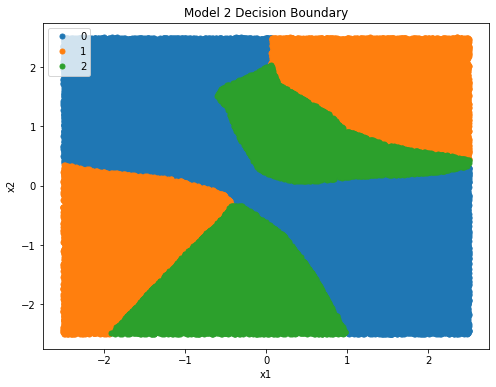

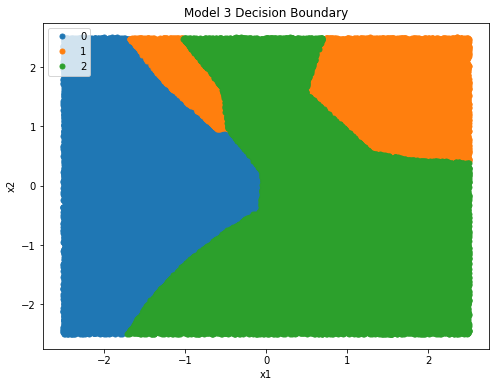

In [202]:
#Initialize the networks
NN_1 = MLP()
NN_1.add_layer('Hidden', dim_in=2, dim_out=16)
NN_1.add_layer('Output', dim_in=16, dim_out=3)
NN_1.add_layer('Softmax', dim_in=3, dim_out=3)

NN_2 = MLP()
NN_2.add_layer('Hidden', dim_in=2, dim_out=16)
NN_2.add_layer('Hidden', dim_in=16, dim_out=16)
NN_2.add_layer('Output', dim_in=16, dim_out=3)
NN_2.add_layer('Softmax', dim_in=3, dim_out=3)

NN_3 = MLP()
NN_3.add_layer('Hidden', dim_in=2, dim_out=16)
NN_3.add_layer('Hidden', dim_in=16, dim_out=8)
NN_3.add_layer('Hidden', dim_in=8, dim_out=3)
NN_3.add_layer('Output', dim_in=3, dim_out=3)
NN_3.add_layer('Softmax', dim_in=3, dim_out=3)

#Train the networks on same data. We fix epochs = 50, batchsize = 8, learning rate = 1e-4
print('*****Training Network 1*****')
loss = NN_1.train(train_X, train_y, epochs=50, bsize=8, learning_rate=1e-4, L2_reg_factor=0, val_X=val_X, val_y=val_y)
plot_loss(loss)

print('*****Training Network 2*****')
loss = NN_2.train(train_X, train_y, epochs=50, bsize=8, learning_rate=1e-4, L2_reg_factor=0, val_X=val_X, val_y=val_y)
plot_loss(loss)

print('*****Training Network 3*****')
loss = NN_3.train(train_X, train_y, epochs=50, bsize=8, learning_rate=1e-4, L2_reg_factor=0, val_X=val_X, val_y=val_y)
plot_loss(loss)

#Plot decision boundaries for the three models:
pred = NN_1.prediction(dummy_data)
plot_data(dummy_data.T, pred.T, 'Model 1 Decision Boundary')

pred = NN_2.prediction(dummy_data)
plot_data(dummy_data.T, pred.T, 'Model 2 Decision Boundary')

pred = NN_3.prediction(dummy_data)
plot_data(dummy_data.T, pred.T, 'Model 3 Decision Boundary')

None of the models appear to achieve the fit of our original model, possibly because there are not enough nodes in the network.</br>

We repeat the same with a L2 regularization factor of $0.001$:

*****Training Network 1*****
Training epoch  1 ... Loss:  14.861427114075646
Validation Accuracy:  25.6
Training epoch  2 ... Loss:  10.424016608576535
Validation Accuracy:  35.9
Training epoch  3 ... Loss:  8.4675903624648
Validation Accuracy:  53.0
Training epoch  4 ... Loss:  7.407349706433099
Validation Accuracy:  65.5
Training epoch  5 ... Loss:  6.751987527379086
Validation Accuracy:  72.2
Training epoch  6 ... Loss:  6.3078637014691905
Validation Accuracy:  73.0
Training epoch  7 ... Loss:  5.975898402956395
Validation Accuracy:  74.7
Training epoch  8 ... Loss:  5.7074052558265596
Validation Accuracy:  75.7
Training epoch  9 ... Loss:  5.476905568557681
Validation Accuracy:  77.2
Training epoch  10 ... Loss:  5.271966353702082
Validation Accuracy:  78.9
Training epoch  11 ... Loss:  5.0854298655847625
Validation Accuracy:  80.7
Training epoch  12 ... Loss:  4.91393317079564
Validation Accuracy:  82.3
Training epoch  13 ... Loss:  4.754475243435922
Validation Accuracy:  83.3
Tra

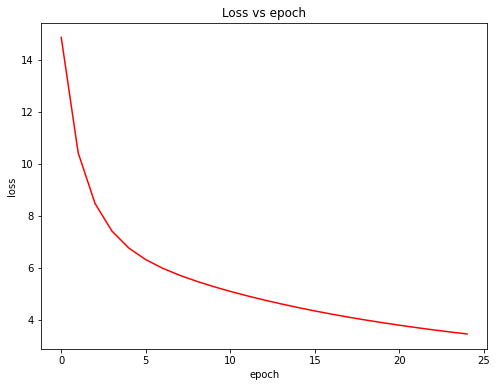

*****Training Network 2*****
Training epoch  1 ... Loss:  11.911487884475285
Validation Accuracy:  57.3
Training epoch  2 ... Loss:  6.6732592309898875
Validation Accuracy:  75.1
Training epoch  3 ... Loss:  5.113202379126096
Validation Accuracy:  83.1
Training epoch  4 ... Loss:  4.398100735349784
Validation Accuracy:  86.1
Training epoch  5 ... Loss:  3.921864820708929
Validation Accuracy:  88.5
Training epoch  6 ... Loss:  3.553824778334302
Validation Accuracy:  90.3
Training epoch  7 ... Loss:  3.2535381461260973
Validation Accuracy:  91.3
Training epoch  8 ... Loss:  3.0031256818635974
Validation Accuracy:  92.30000000000001
Training epoch  9 ... Loss:  2.7921974216988406
Validation Accuracy:  92.7
Training epoch  10 ... Loss:  2.6119405778528053
Validation Accuracy:  93.2
Training epoch  11 ... Loss:  2.456519723963645
Validation Accuracy:  93.7
Training epoch  12 ... Loss:  2.3224757939421092
Validation Accuracy:  94.19999999999999
Training epoch  13 ... Loss:  2.205692079298878

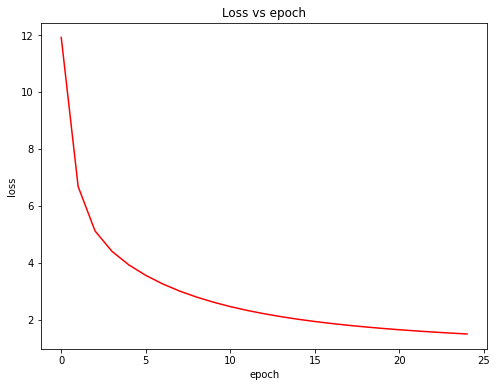

*****Training Network 3*****
Training epoch  1 ... Loss:  9.453961540582954
Validation Accuracy:  56.2
Training epoch  2 ... Loss:  7.778271984368875
Validation Accuracy:  64.5
Training epoch  3 ... Loss:  7.105996340979872
Validation Accuracy:  70.3
Training epoch  4 ... Loss:  6.630776164219655
Validation Accuracy:  73.4
Training epoch  5 ... Loss:  6.252146879236405
Validation Accuracy:  76.7
Training epoch  6 ... Loss:  5.922625981113125
Validation Accuracy:  78.4
Training epoch  7 ... Loss:  5.617260816799214
Validation Accuracy:  79.80000000000001
Training epoch  8 ... Loss:  5.327799995473054
Validation Accuracy:  81.5
Training epoch  9 ... Loss:  5.056349461923079
Validation Accuracy:  83.6
Training epoch  10 ... Loss:  4.808037766933899
Validation Accuracy:  85.3
Training epoch  11 ... Loss:  4.584368883764983
Validation Accuracy:  87.5
Training epoch  12 ... Loss:  4.384684220755583
Validation Accuracy:  88.8
Training epoch  13 ... Loss:  4.2064129356127555
Validation Accurac

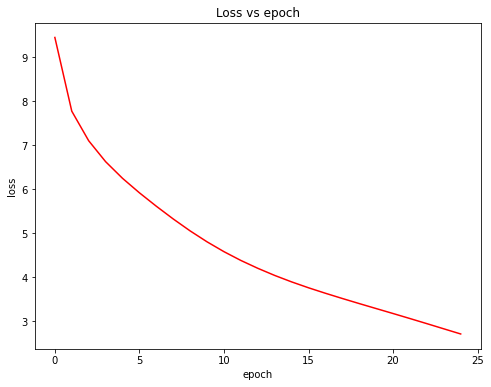

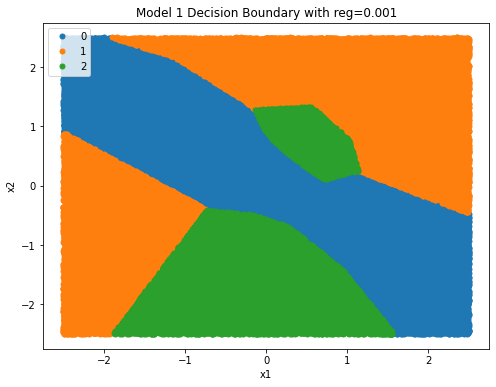

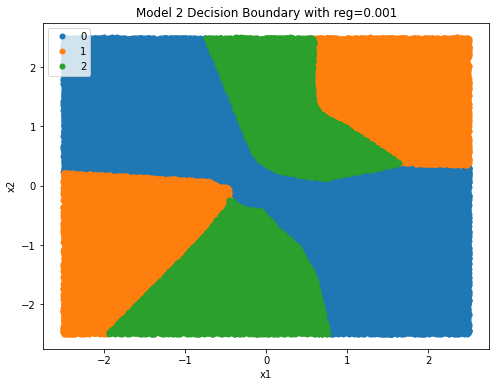

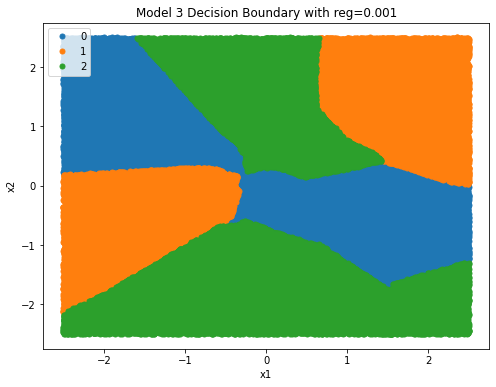

In [204]:
#Initialize the networks
NN_1 = MLP()
NN_1.add_layer('Hidden', dim_in=2, dim_out=16)
NN_1.add_layer('Output', dim_in=16, dim_out=3)
NN_1.add_layer('Softmax', dim_in=3, dim_out=3)

NN_2 = MLP()
NN_2.add_layer('Hidden', dim_in=2, dim_out=16)
NN_2.add_layer('Hidden', dim_in=16, dim_out=16)
NN_2.add_layer('Output', dim_in=16, dim_out=3)
NN_2.add_layer('Softmax', dim_in=3, dim_out=3)

NN_3 = MLP()
NN_3.add_layer('Hidden', dim_in=2, dim_out=16)
NN_3.add_layer('Hidden', dim_in=16, dim_out=8)
NN_3.add_layer('Hidden', dim_in=8, dim_out=3)
NN_3.add_layer('Output', dim_in=3, dim_out=3)
NN_3.add_layer('Softmax', dim_in=3, dim_out=3)

#Train the networks on same data. We fix epochs = 25, batchsize = 8, learning rate = 1e-4, regularization factor = 0.001
print('*****Training Network 1*****')
loss = NN_1.train(train_X, train_y, epochs=25, bsize=8, learning_rate=1e-4, L2_reg_factor=0.001, val_X=val_X, val_y=val_y)
plot_loss(loss)

print('*****Training Network 2*****')
loss = NN_2.train(train_X, train_y, epochs=25, bsize=8, learning_rate=1e-4, L2_reg_factor=0.001, val_X=val_X, val_y=val_y)
plot_loss(loss)

print('*****Training Network 3*****')
loss = NN_3.train(train_X, train_y, epochs=25, bsize=8, learning_rate=1e-4, L2_reg_factor=0.001, val_X=val_X, val_y=val_y)
plot_loss(loss)

#Plot decision boundaries for the three models:
pred = NN_1.prediction(dummy_data)
plot_data(dummy_data.T, pred.T, 'Model 1 Decision Boundary with reg=0.001')

pred = NN_2.prediction(dummy_data)
plot_data(dummy_data.T, pred.T, 'Model 2 Decision Boundary with reg=0.001')

pred = NN_3.prediction(dummy_data)
plot_data(dummy_data.T, pred.T, 'Model 3 Decision Boundary with reg=0.001')

## (d) Repeating with different dataset - Credit Card Payment Default
We use the Credit Card Default dataset from the R datasets library (https://vincentarelbundock.github.io/Rdatasets/datasets.html) for this task. The dataset contains 10k rows of customer data with three features (shown below). We will perform prediction on this data to determine if the customer has defaulted the payment or not.

We will start by preparing the data. The dataset contains 3 features and 2 classes:

In [219]:
#Loading data
default = pd.read_csv('Default.csv')
display(default)

,student,balance,income,default
0,0,729.526495,44361.62507,0
1,1,817.180407,12106.13470,0
2,0,1073.549164,31767.13895,0
3,0,529.250605,35704.49394,0
4,0,785.655883,38463.49588,0
...,...,...,...,...
9995,0,711.555020,52992.37891,0
9996,0,757.962918,19660.72177,0
9997,0,845.411989,58636.15698,0
9998,0,1569.009053,36669.11236,0


We separate the data into train, validation and test sets:

In [220]:
#Separate into train,test,validation sets
default_train = default.sample(frac = 0.8)
default_test = default.drop(default_train.index)
default_val = default_test.sample(frac = 0.5)
default_test = default_test.drop(default_val.index)

#Separate into Xs, Ys and Normalize
default_train_X = default_train.iloc[:,:-1]
default_train_X = (default_train_X - default_train_X.mean())/default_train_X.std()
default_train_X = np.matrix(default_train_X.values)
default_train_y = default_train.iloc[:,-1]
default_train_y = np.matrix(np.expand_dims(default_train_y.values,axis=1))

default_test_X = default_test.iloc[:,:-1]
default_test_X = (default_test_X - default_test_X.mean())/default_test_X.std()
default_test_X = np.matrix(default_test_X.values)
default_test_y = default_test.iloc[:,-1]
default_test_y = np.matrix(np.expand_dims(default_test_y.values,axis=1))

default_val_X = default_val.iloc[:,:-1]
default_val_X = (default_val_X - default_val_X.mean())/default_val_X.std()
default_val_X = np.matrix(default_val_X.values)
default_val_y = default_val.iloc[:,-1]
default_val_y = np.matrix(np.expand_dims(default_val_y.values,axis=1))

print(default_train_X.shape)
print(default_train_y.shape)
print(default_val_X.shape)
print(default_val_y.shape)
print(default_test_X.shape)
print(default_test_y.shape)

(8000, 3)
(8000, 1)
(1000, 3)
(1000, 1)
(1000, 3)
(1000, 1)


We train the model for 100 epochs. Note that our training function supports early stopping via the val_threshold parameter. So, we also add a validation threshold of 96.5% and stop the training when the threshold is reached. Finally, we perform prediction on the test set and evaluate the accuracy:

Training epoch  1 ... Loss:  10.459553058104918
Validation Accuracy:  83.7
Training epoch  2 ... Loss:  2.3206077992747987
Validation Accuracy:  95.7
Training epoch  3 ... Loss:  1.7030971166202495
Validation Accuracy:  95.8
Training epoch  4 ... Loss:  1.481484346382232
Validation Accuracy:  95.8
Training epoch  5 ... Loss:  1.3427409856806383
Validation Accuracy:  95.8
Training epoch  6 ... Loss:  1.2441715070658725
Validation Accuracy:  95.8
Training epoch  7 ... Loss:  1.1706925156186712
Validation Accuracy:  95.8
Training epoch  8 ... Loss:  1.1132170804566734
Validation Accuracy:  95.89999999999999
Training epoch  9 ... Loss:  1.0667233175317654
Validation Accuracy:  96.1
Training epoch  10 ... Loss:  1.0282394002206257
Validation Accuracy:  96.2
Training epoch  11 ... Loss:  0.9958829160975861
Validation Accuracy:  96.2
Training epoch  12 ... Loss:  0.9681110959345516
Validation Accuracy:  96.2
Training epoch  13 ... Loss:  0.9440332198666881
Validation Accuracy:  96.2
Training 

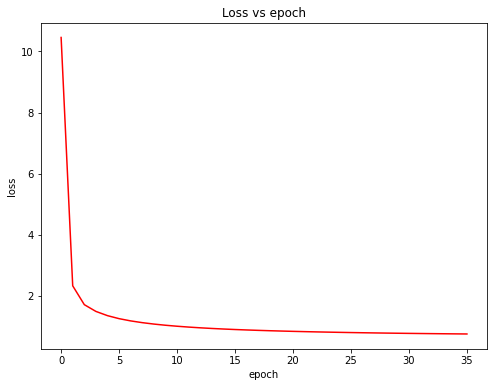

Accuracy on test set:  96.6


In [249]:
#Initialize the model
default_NN = MLP()
default_NN.add_layer('Hidden', dim_in=3, dim_out=32)
default_NN.add_layer('Hidden', dim_in=32, dim_out=32)
default_NN.add_layer('Output', dim_in=32, dim_out=2)
default_NN.add_layer('Softmax', dim_in=2, dim_out=2)

#Train the model
loss = default_NN.train(default_train_X, default_train_y, epochs=100, bsize=8, learning_rate=1e-5, L2_reg_factor=0.02, val_X=default_val_X, val_y=default_val_y, val_threshold=0.965)
plot_loss(loss)
#Compute test accuracy
pred = default_NN.prediction(default_test_X.T)
test_len = default_test_X.shape[0]
correct_pred_count = np.sum(pred == default_test_y.T)
print("Accuracy on test set: ",(correct_pred_count*100/test_len))